# Spotify Recommender Playlist

#### Source: [Deep Learning Turkey](https://medium.com/deep-learning-turkey/build-your-own-spotify-playlist-of-best-playlist-recommendations-fc9ebe92826a)
#### [Spotify Developer Key](https://developer.spotify.com/dashboard/applications/692c6ca99e4e418ea42a1a79ce970a04)

In [10]:
# Create a conda virtual environment

# !conda create -n spotify_playlist_rec python=3.8 pandas scikit-learn matplotlib seaborn scipy jupyter
# !pip install spotipy

# If the above does not work for you, manually download the packages via pip

# !pip install pandas
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn
# !pip install scipy
# !pip install jupyter
# !pip install spotipy

#### Import Spotipy library - you may want to check documentation [here](https://spotipy.readthedocs.io/en/latest/).
Authorize a token at a scope containing at least “playlist-modify-public” access (You may add more to your scope. For available scopes see [here](https://developer.spotify.com/documentation/general/guides/scopes/)).

In [26]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

cid ='692c6ca99e4e418ea42a1a79ce970a04' # Client ID; copy this from your app 
secret = '805e9c8f7c8b401d88edc00604aa300f' # Client Secret; copy this from your app
username = 'Vivek Jha' # Your Spotify username

#for avaliable scopes see https://developer.spotify.com/web-api/using-scopes/
scope = 'user-library-read playlist-modify-public playlist-read-private'

redirect_uri='https://developer.spotify.com/dashboard/applications/692c6ca99e4e418ea42a1a79ce970a04' # Paste your Redirect URI here

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
token = util.prompt_for_user_token(username, scope, cid, secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)


#### Load your source playlist as a dataframe with audio features, setting track names as indices. You will get used to the way Spotify stores data in playlists after a plenty of experiments.


In [27]:
#Create a dataframe of your playlist including tracks' names and audio features
import pandas as pd

# https://open.spotify.com/playlist/3YJqZuOCONKv1My6NfM1t9
# sourcePlaylistID = '34rdtt0yzrwDbvnkCb3xaP'
sourcePlaylistID = '3YJqZuOCONKv1My6NfM1t9'
sourcePlaylist = sp.user_playlist(username, sourcePlaylistID);
tracks = sourcePlaylist['tracks'];
songs = tracks['items'];

track_ids = []
track_names = []

for i in range(len(songs)):
    if songs[i]['track']['id'] is not None: # Removes the local tracks in your playlist if there is any
        track_ids.append(songs[i]['track']['id'])
        track_names.append(songs[i]['track']['name'])

features = []
for i in range(len(track_ids)):
    audio_features = sp.audio_features(track_ids[i])
    for track in audio_features:
        features.append(track)

playlist_df = pd.DataFrame(features, index=track_names)
print(playlist_df.shape)

(31, 18)


#### One of the important steps here in the above code is to make it ignore local tracks in your source playlist if any. It is possible to add local tracks to a playlist from your local machine but these tracks will not have track ids or acoustic features so we will not be able to use them here

In [28]:
# Pick only relevant features;
playlist_df = playlist_df[
    ['id',
     'acousticness',
     'danceability',
     'duration_ms',
     'energy',
     'instrumentalness',
     'key',
     'liveness',
     'loudness',
     'mode',
     'speechiness',
     'tempo',
     'valence']
]

#### Rate each track in your playlist with respect to its relevance to your Playlist so that our project becomes a multi-class classification task. Add this rating as a target column to your source playlist dataframe. For my example I used a rating from 1 to 10;


In [29]:
playlist_df['ratings'] = [10, 9, 9, 10, 8, 6, 8, 4, 3, 5, 7, 5, 5, 8, 8, 7, 8, 8, 10, 8, 10, 8, 4, 4, 4, 10, 10, 9, 8, 8, 4]

In [30]:
# From now on, your source playlist dataframe will be your training set
X_train = playlist_df.drop(['id', 'ratings'], axis=1)
y_train = playlist_df['ratings']

#### We will be using PCA to reduce the dimensionality of our dataset.

##### Won't go too much into the details, but this is a standard feature engineering technique to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.
##### Learn more about it [here](https://www.wikiwand.com/en/Principal_component_analysis).

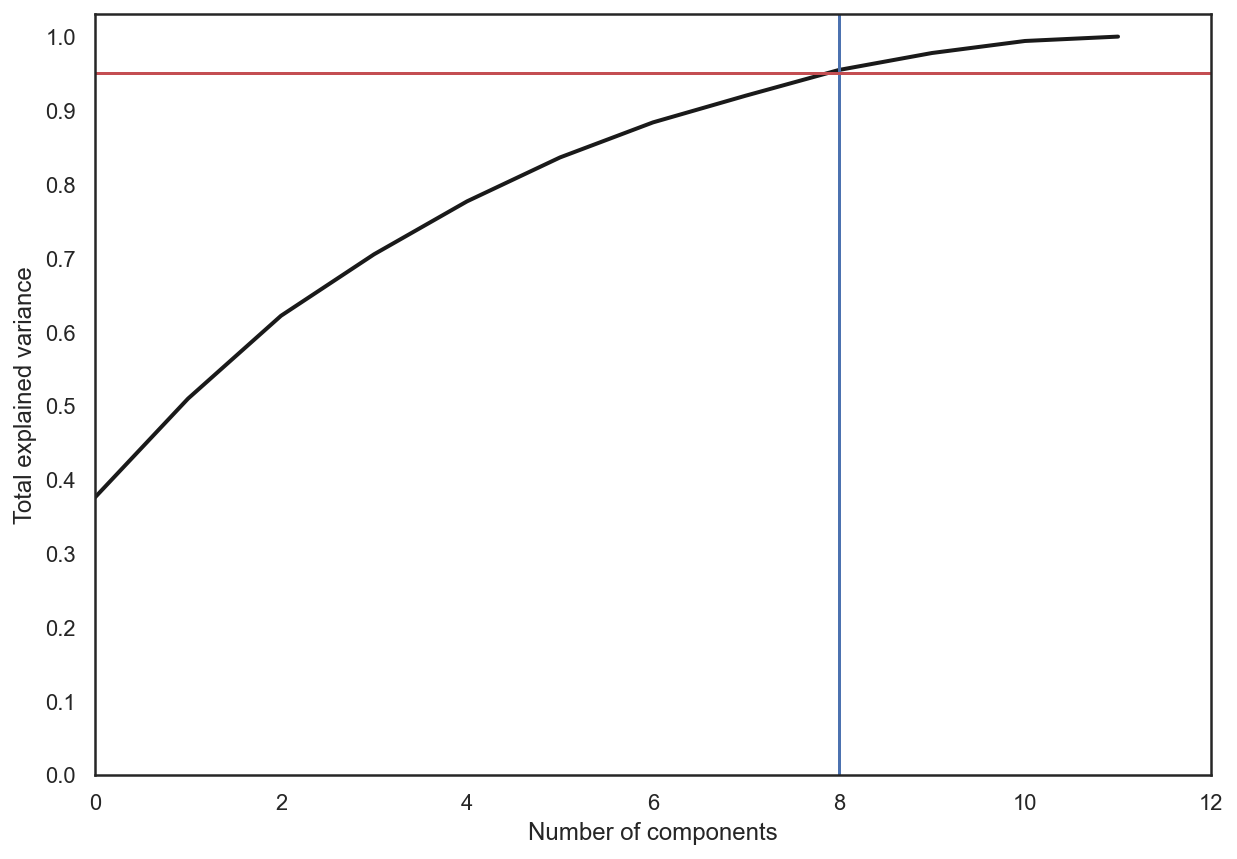

In [42]:
# Apply pca to the scaled train set first

import numpy as np
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

X_scaled = StandardScaler().fit_transform(X_train)

pca = decomposition.PCA().fit(X_scaled)

plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 12)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(8, c='b') # Tune this so that you obtain at least a 95% total variance explained
plt.axhline(0.95, c='r')
plt.show();

In [44]:
# Fit your dataset to the optimal pca
pca = decomposition.PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

#### Now optionally, apply [tf-idf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) vectorizer to the names of your tracks. Actually, this is optional because, Spotify will already do this for your tracks with more advanced techniques like [Word2Vec](https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484) and [Annoy](https://github.com/spotify/annoy) behind the scenes, when we call the Spotipy’s track recommendation function.

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 6), max_features=10000)
X_names_sparse = v.fit_transform(track_names)
X_names_sparse.shape

(31, 295)

In [46]:
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# combine the two into one last training set
X_train_last = csr_matrix(hstack([X_pca, X_names_sparse]))
# Initialize a stratified 5-fold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)